# Pregunta 4: 
### ¿Ha cambiado la recaudación promedio de los top-10 blockbusters a lo largo del tiempo?
# Técnica: 
### Análisis mediante ANOVA por décadas (Prueba de Hipótesis)

## 1. Configuración inicial

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import os
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Crear carpeta para gráficos de esta pregunta
graphics_folder = 'graphics/pregunta4'
if not os.path.exists(graphics_folder):
    os.makedirs(graphics_folder)
    print(f"✓ Carpeta creada: {graphics_folder}/")

# Crear carpeta para resultados
results_folder = 'results'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    print(f"✓ Carpeta creada: {results_folder}/")


## 2. Cargar datos limpios

In [12]:
print("📂 CARGANDO DATOS PROCESADOS...")
try:
    # Intentar cargar desde la carpeta data
    df = pd.read_csv('data/Blockbusters_Limpio.csv')
    print(f"✓ Datos limpios cargados exitosamente desde: data/Blockbusters_Limpio.csv")
    print(f"  • {df.shape[0]} películas, {df.shape[1]} variables")
    
    # Verificar que tenemos las columnas necesarias
    required_columns = ['release_year', 'worldwide_gross', 'decade_label']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"⚠ Advertencia: Faltan columnas {missing_columns}")
        print("  Creando variables necesarias...")
        
        if 'release_year' in df.columns and 'decade_label' not in df.columns:
            df['decade'] = (df['release_year'] // 10) * 10
            df['decade_label'] = df['decade'].astype(str) + 's'
            print("  ✓ Variables de década creadas")
            
except FileNotFoundError:
    print("⚠ No se encontró el archivo limpio, cargando original...")
    try:
        df = pd.read_csv('Blockbusters_2019-1977.csv', encoding='latin1')
        
        # Limpiar columnas numéricas
        columnas_numericas = ['film_budget', 'worldwide_gross', 'domestic_gross']
        for col in columnas_numericas:
            if col in df.columns:
                df[col] = df[col].astype(str).str.replace(',', '').str.replace('$', '')
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        # Crear variables de década
        df['decade'] = (df['release_year'] // 10) * 10
        df['decade_label'] = df['decade'].astype(str) + 's'
        
        print("✓ Datos originales cargados y transformados")
        
    except FileNotFoundError:
        print("❌ ERROR: No se encontró ningún archivo de datos")
        print("  Por favor, ejecuta primero Analisis_Blockbusters_Main.ipynb")
        raise


📂 CARGANDO DATOS PROCESADOS...
✓ Datos limpios cargados exitosamente desde: data/Blockbusters_Limpio.csv
  • 430 películas, 18 variables


## 3. Análisis Exploratorio Inicial - Recaudación por Década

In [13]:
print("\n" + "="*70)
print("ANÁLISIS DE RECAUDACIÓN POR DÉCADA")
print("="*70)

# Asegurar que las décadas estén en orden cronológico
if 'decade_label' in df.columns:
    # Extraer el año numérico de la etiqueta para ordenar
    df['decade_numeric'] = df['decade_label'].str.replace('s', '').astype(int)
    df = df.sort_values('decade_numeric')
    decades_ordered = sorted(df['decade_label'].unique(), 
                            key=lambda x: int(x.replace('s', '')))

# Estadísticas descriptivas por década
print("\n📊 ESTADÍSTICAS DESCRIPTIVAS POR DÉCADA:")
stats_decada = df.groupby('decade_label')['worldwide_gross'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).reindex(decades_ordered)

# Formatear para mejor visualización
def format_currency(x):
    """Formatear valores monetarios"""
    if pd.isna(x):
        return "N/A"
    elif x >= 1e9:
        return f"${x/1e9:.2f}B"
    elif x >= 1e6:
        return f"${x/1e6:.1f}M"
    else:
        return f"${x:,.0f}"

# Crear versión formateada para mostrar
stats_decada_display = stats_decada.copy()
for col in ['mean', 'min', 'max', 'median']:
    stats_decada_display[col] = stats_decada_display[col].apply(format_currency)

print(stats_decada_display)



ANÁLISIS DE RECAUDACIÓN POR DÉCADA

📊 ESTADÍSTICAS DESCRIPTIVAS POR DÉCADA:
              count     mean           std      min      max   median
decade_label                                                         
1970s            30  $125.7M  1.112432e+08   $37.2M  $503.0M   $83.7M
1980s           100  $163.4M  1.161433e+08   $42.4M  $663.4M  $113.1M
1990s           100  $370.7M  2.103834e+08  $179.0M   $1.85B  $326.3M
2000s           100  $608.2M  2.984687e+08  $273.3M   $2.74B  $539.2M
2010s           100  $967.3M  3.536428e+08  $494.9M   $2.80B  $874.5M


## 4. Visualización de la tendencia temporal


📊 CREANDO VISUALIZACIONES...
✓ Guardado: graphics/pregunta4\Tendencias_Temporales_Recaudacion.png


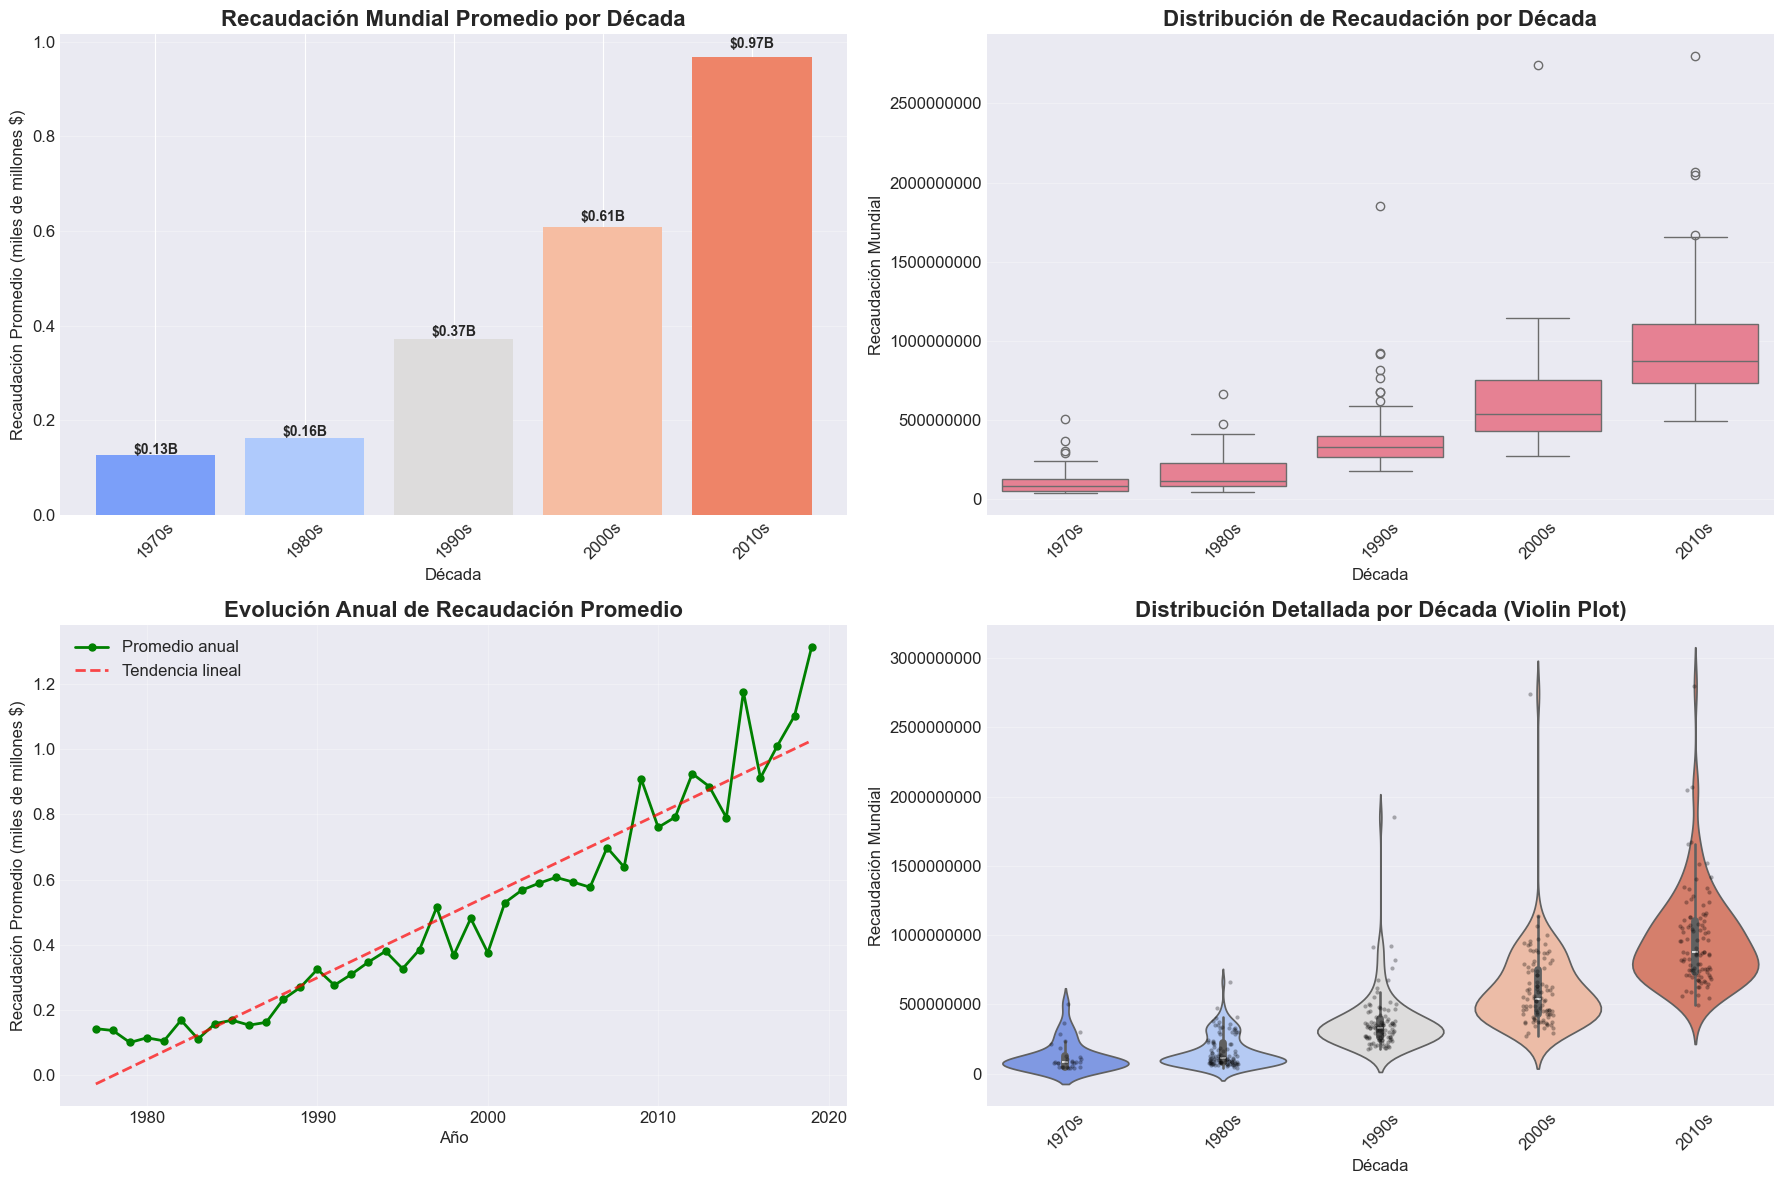

In [14]:
print("\n📊 CREANDO VISUALIZACIONES...")

# Gráfico 1: Evolución de recaudación promedio por década (Gráfico combinado)
fig = plt.figure(figsize=(18, 12))

# Subplot 1: Barras de recaudación promedio
ax1 = plt.subplot(2, 2, 1)
promedio_decada = df.groupby('decade_label')['worldwide_gross'].mean().reindex(decades_ordered)

bars = ax1.bar(range(len(promedio_decada)), promedio_decada.values / 1e9,
               color=plt.cm.coolwarm(np.linspace(0.2, 0.8, len(promedio_decada))))

ax1.set_title('Recaudación Mundial Promedio por Década', fontsize=16, fontweight='bold')
ax1.set_xlabel('Década')
ax1.set_ylabel('Recaudación Promedio (miles de millones $)')
ax1.set_xticks(range(len(promedio_decada)))
ax1.set_xticklabels(promedio_decada.index, rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for i, (bar, v) in enumerate(zip(bars, promedio_decada.values / 1e9)):
    ax1.text(i, v * 1.02, f'${v:.2f}B', ha='center', fontsize=10, fontweight='bold')

# Subplot 2: Boxplot por década
ax2 = plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='decade_label', y='worldwide_gross', 
            order=decades_ordered, ax=ax2)
ax2.set_title('Distribución de Recaudación por Década', fontsize=16, fontweight='bold')
ax2.set_xlabel('Década')
ax2.set_ylabel('Recaudación Mundial')
ax2.ticklabel_format(style='plain', axis='y')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Subplot 3: Línea de tendencia anual
ax3 = plt.subplot(2, 2, 3)
promedio_anual = df.groupby('release_year')['worldwide_gross'].mean().sort_index()
ax3.plot(promedio_anual.index, promedio_anual.values / 1e9, 
         marker='o', color='green', linewidth=2, markersize=5, label='Promedio anual')

# Agregar línea de tendencia
if len(promedio_anual) > 1:
    z = np.polyfit(promedio_anual.index, promedio_anual.values / 1e9, 1)
    p = np.poly1d(z)
    ax3.plot(promedio_anual.index, p(promedio_anual.index), 
             "r--", alpha=0.7, linewidth=2, label='Tendencia lineal')

ax3.set_title('Evolución Anual de Recaudación Promedio', fontsize=16, fontweight='bold')
ax3.set_xlabel('Año')
ax3.set_ylabel('Recaudación Promedio (miles de millones $)')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Subplot 4: Violin plot por década
ax4 = plt.subplot(2, 2, 4)
sns.violinplot(data=df, x='decade_label', y='worldwide_gross', 
               order=decades_ordered, ax=ax4, palette='coolwarm')
sns.stripplot(data=df, x='decade_label', y='worldwide_gross', 
              order=decades_ordered, size=3, color='black', alpha=0.3, ax=ax4)
ax4.set_title('Distribución Detallada por Década (Violin Plot)', fontsize=16, fontweight='bold')
ax4.set_xlabel('Década')
ax4.set_ylabel('Recaudación Mundial')
ax4.ticklabel_format(style='plain', axis='y')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# Guardar el gráfico combinado
ruta_grafico_combinado = os.path.join(graphics_folder, 'Tendencias_Temporales_Recaudacion.png')
plt.savefig(ruta_grafico_combinado, dpi=300, bbox_inches='tight')
print(f"✓ Guardado: {ruta_grafico_combinado}")
plt.show()
plt.close()


## 5. Prueba de Hipótesis - ANOVA por décadas

In [15]:
print("\n" + "="*70)
print("PRUEBA DE HIPÓTESIS: ANOVA POR DÉCADAS")
print("="*70)

# Hipótesis:
# H0: No hay diferencia significativa en la recaudación promedio entre décadas
# H1: Al menos una década tiene una recaudación promedio diferente

# Preparar datos para ANOVA
decadas = df['decade_label'].unique()
grupos = [df[df['decade_label'] == decada]['worldwide_gross'].dropna().values 
          for decada in decadas]

# Verificar supuestos del ANOVA
print("\n1. VERIFICACIÓN DE SUPUESTOS DEL ANOVA:")

# Supuesto 1: Normalidad (Shapiro-Wilk por grupo)
print("\n   a) Prueba de Normalidad (Shapiro-Wilk):")
normalidad_results = []
for i, (grupo, decada) in enumerate(zip(grupos, decadas)):
    if len(grupo) >= 3 and len(grupo) <= 5000:  # Shapiro tiene límites
        stat, p_valor = stats.shapiro(grupo)
        normalidad_results.append({
            'Década': decada,
            'n': len(grupo),
            'Estadístico_W': round(stat, 4),
            'p-valor': round(p_valor, 4),
            'Normal?': 'Sí' if p_valor > 0.05 else 'No'
        })
    else:
        normalidad_results.append({
            'Década': decada,
            'n': len(grupo),
            'Estadístico_W': 'N/A',
            'p-valor': 'N/A',
            'Normal?': 'No aplica'
        })

df_normalidad = pd.DataFrame(normalidad_results)
print(df_normalidad.to_string(index=False))

# Supuesto 2: Homogeneidad de varianzas (Levene's test)
print(f"\n   b) Homogeneidad de Varianzas (Levene's test):")
try:
    stat_levene, p_levene = stats.levene(*grupos)
    print(f"      Estadístico: {stat_levene:.4f}")
    print(f"      p-valor: {p_levene:.4f}")
    print(f"      Varianzas homogéneas?: {'Sí' if p_levene > 0.05 else 'No'}")
except Exception as e:
    print(f"      Error en test de Levene: {e}")
    print("      Usando test de Bartlett como alternativa...")
    try:
        stat_bartlett, p_bartlett = stats.bartlett(*grupos)
        print(f"      Estadístico Bartlett: {stat_bartlett:.4f}")
        print(f"      p-valor: {p_bartlett:.4f}")
        print(f"      Varianzas homogéneas?: {'Sí' if p_bartlett > 0.05 else 'No'}")
    except:
        print("      No se pudo realizar la prueba de homogeneidad de varianzas")



PRUEBA DE HIPÓTESIS: ANOVA POR DÉCADAS

1. VERIFICACIÓN DE SUPUESTOS DEL ANOVA:

   a) Prueba de Normalidad (Shapiro-Wilk):
Década   n  Estadístico_W  p-valor Normal?
 1970s  30         0.7365      0.0      No
 1980s 100         0.8150      0.0      No
 1990s 100         0.6442      0.0      No
 2000s 100         0.7010      0.0      No
 2010s 100         0.8313      0.0      No

   b) Homogeneidad de Varianzas (Levene's test):
      Estadístico: 11.0726
      p-valor: 0.0000
      Varianzas homogéneas?: No


## 6. Ejecutar ANOVA

In [16]:
print("\n2. RESULTADOS DEL ANOVA UNIDIRECCIONAL:")

# Método 1: Usando scipy.stats
f_stat, p_valor_anova = stats.f_oneway(*grupos)
print(f"   F-estadístico: {f_stat:.4f}")
print(f"   p-valor: {p_valor_anova:.4f}")

# Interpretación
alpha = 0.05
if p_valor_anova < alpha:
    print(f"   📈 CONCLUSIÓN: Se rechaza H0 (p < {alpha}).")
    print("   Hay evidencia estadística de diferencias significativas entre décadas.")
else:
    print(f"   📉 CONCLUSIÓN: No se rechaza H0 (p ≥ {alpha}).")
    print("   No hay evidencia de diferencias significativas entre décadas.")

# Método 2: ANOVA usando statsmodels (para obtener tabla completa)
print("\n3. TABLA ANOVA DETALLADA (statsmodels):")
try:
    modelo_anova = ols('worldwide_gross ~ C(decade_label)', data=df).fit()
    tabla_anova = sm.stats.anova_lm(modelo_anova, typ=2)
    print(tabla_anova.round(4))
    
    # Calcular tamaño del efecto
    ss_between = tabla_anova['sum_sq'][0]
    ss_total = tabla_anova['sum_sq'].sum()
    eta_squared = ss_between / ss_total if ss_total > 0 else 0
    
except Exception as e:
    print(f"   Error en ANOVA con statsmodels: {e}")
    # Usar valores del ANOVA de scipy
    eta_squared = f_stat / (f_stat + (df['worldwide_gross'].count() - len(decadas)))
    print("   Se calculó eta cuadrado basado en el F-estadístico")



2. RESULTADOS DEL ANOVA UNIDIRECCIONAL:
   F-estadístico: 156.6101
   p-valor: 0.0000
   📈 CONCLUSIÓN: Se rechaza H0 (p < 0.05).
   Hay evidencia estadística de diferencias significativas entre décadas.

3. TABLA ANOVA DETALLADA (statsmodels):
                       sum_sq     df         F  PR(>F)
C(decade_label)  4.020526e+19    4.0  156.6101     0.0
Residual         2.727671e+19  425.0       NaN     NaN


## 7. Prueba POST-HOC (TUKEY HSD)


PRUEBA POST-HOC: TUKEY HSD
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
group1 group2   meandiff   p-adj       lower          upper      reject
-----------------------------------------------------------------------
 1970s  1980s  37782453.58 0.9527 -106690943.8062 182255850.9662  False
 1970s  1990s 245088107.61    0.0  100614710.2238 389561504.9962   True
 1970s  2000s 482500639.69    0.0  338027242.3038 626974037.0762   True
 1970s  2010s 841607984.89    0.0  697134587.5038 986081382.2762   True
 1980s  1990s 207305654.03    0.0  109155308.0869 305455999.9731   True
 1980s  2000s 444718186.11    0.0  346567840.1669 542868532.0531   True
 1980s  2010s 803825531.31    0.0  705675185.3669 901975877.2531   True
 1990s  2000s 237412532.08    0.0  139262186.1369 335562878.0231   True
 1990s  2010s 596519877.28    0.0  498369531.3369 694670223.2231   True
 2000s  2010s  359107345.2    0.0  260956999.2569 457257691.1431   True
------------------------------------

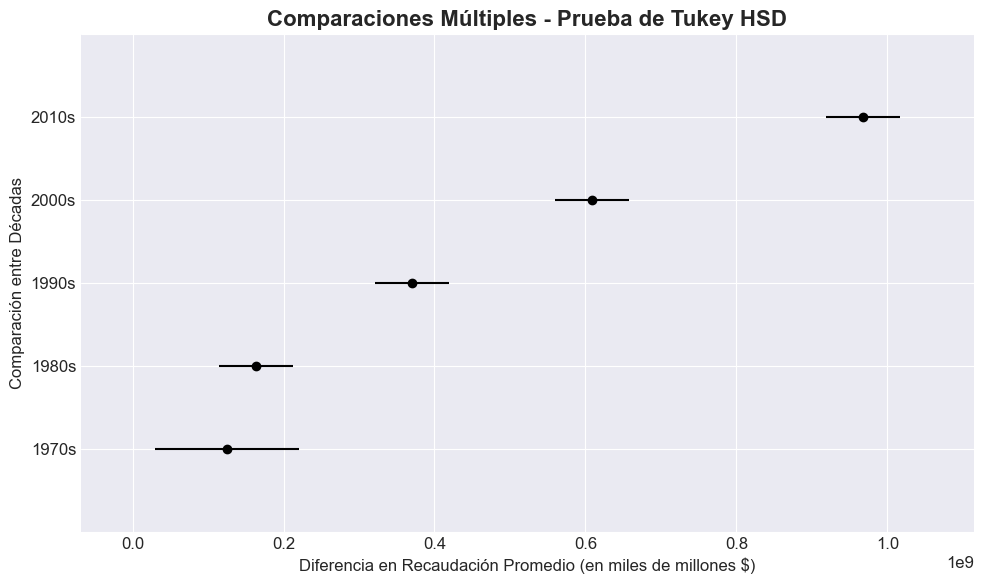


📌 RESUMEN DE DIFERENCIAS SIGNIFICATIVAS ENTRE DÉCADAS:
group1 group2 meandiff_formatted  p-adj
 1970s  1990s             $+245M    0.0
 1970s  2000s             $+483M    0.0
 1970s  2010s             $+842M    0.0
 1980s  1990s             $+207M    0.0
 1980s  2000s             $+445M    0.0
 1980s  2010s             $+804M    0.0
 1990s  2000s             $+237M    0.0
 1990s  2010s             $+597M    0.0
 2000s  2010s             $+359M    0.0


In [17]:

if p_valor_anova < alpha:
    print("\n" + "="*70)
    print("PRUEBA POST-HOC: TUKEY HSD")
    print("="*70)
    
    # Preparar datos para Tukey
    tukey_data = df[['decade_label', 'worldwide_gross']].dropna()
    
    # Ejecutar prueba de Tukey
    try:
        tukey_result = pairwise_tukeyhsd(
            endog=tukey_data['worldwide_gross'],
            groups=tukey_data['decade_label'],
            alpha=alpha
        )
        
        # Mostrar resultados
        print(tukey_result)
        
        # Visualizar comparaciones
        fig, ax = plt.subplots(figsize=(12, 8))
        tukey_result.plot_simultaneous(ax=ax)
        ax.set_title('Comparaciones Múltiples - Prueba de Tukey HSD', 
                     fontsize=16, fontweight='bold')
        ax.set_xlabel('Diferencia en Recaudación Promedio (en miles de millones $)')
        ax.set_ylabel('Comparación entre Décadas')
        plt.tight_layout()
        
        ruta_tukey = os.path.join(graphics_folder, 'Tukey_HSD_Resultados.png')
        plt.savefig(ruta_tukey, dpi=300, bbox_inches='tight')
        print(f"\n✓ Guardado: {ruta_tukey}")
        plt.show()
        plt.close()
        
        # Crear tabla resumen de diferencias significativas
        print("\n📌 RESUMEN DE DIFERENCIAS SIGNIFICATIVAS ENTRE DÉCADAS:")
        summary = tukey_result.summary()
        df_tukey = pd.DataFrame(summary.data[1:], columns=summary.data[0])
        
        # Convertir columnas numéricas
        numeric_cols = ['meandiff', 'lower', 'upper', 'p-adj']
        for col in numeric_cols:
            if col in df_tukey.columns:
                df_tukey[col] = pd.to_numeric(df_tukey[col], errors='coerce')
        
        # Filtrar solo diferencias significativas
        df_significativas = df_tukey[df_tukey['reject'] == True].copy()
        if len(df_significativas) > 0:
            # Formatear para mejor visualización
            df_significativas['meandiff_formatted'] = df_significativas['meandiff'].apply(
                lambda x: f"${x/1e9:+.2f}B" if abs(x) >= 1e9 else f"${x/1e6:+.0f}M"
            )
            print(df_significativas[['group1', 'group2', 'meandiff_formatted', 'p-adj']].to_string(index=False))
        else:
            print("No se encontraron diferencias significativas entre pares específicos.")
            
    except Exception as e:
        print(f"   Error en prueba de Tukey HSD: {e}")
        print("   Considera usar prueba de Games-Howell si no se cumplen supuestos de ANOVA")


## 8. Análisis de potencia estadística

In [18]:
print("\n" + "="*70)
print("ANÁLISIS DE POTENCIA ESTADÍSTICA")
print("="*70)

# Calcular tamaño del efecto (eta cuadrado)
if 'eta_squared' not in locals():
    # Calcular eta cuadrado manualmente si no se calculó antes
    if 'ss_between' in locals() and 'ss_total' in locals():
        eta_squared = ss_between / ss_total if ss_total > 0 else 0
    else:
        # Estimación aproximada
        eta_squared = f_stat / (f_stat + (len(df) - len(decadas)))

print(f"Tamaño del efecto (eta cuadrado): {eta_squared:.4f}")
print("Interpretación del tamaño del efecto (Cohen, 1988):")
if eta_squared < 0.01:
    print("  - Efecto muy pequeño (η² < 0.01)")
elif eta_squared < 0.06:
    print("  - Efecto pequeño (0.01 ≤ η² < 0.06)")
elif eta_squared < 0.14:
    print("  - Efecto moderado (0.06 ≤ η² < 0.14)")
else:
    print("  - Efecto grande (η² ≥ 0.14)")

# Calcular potencia estadística aproximada
if p_valor_anova < alpha:
    print(f"\nPotencia estadística: Alta (p < {alpha})")
else:
    print(f"\nPotencia estadística: Baja o muestra insuficiente (p ≥ {alpha})")



ANÁLISIS DE POTENCIA ESTADÍSTICA
Tamaño del efecto (eta cuadrado): 0.5958
Interpretación del tamaño del efecto (Cohen, 1988):
  - Efecto grande (η² ≥ 0.14)

Potencia estadística: Alta (p < 0.05)


## 9. Resultados y Conclusiones

In [19]:
print("\n" + "="*70)
print("CONCLUSIONES FINALES - PREGUNTA 4")
print("="*70)

print("\n📋 RESUMEN EJECUTIVO:")
print(f"1. Período analizado: {df['release_year'].min()} - {df['release_year'].max()}")
print(f"2. Total de películas: {len(df)}")
print(f"3. Décadas analizadas: {', '.join(sorted(decades_ordered))}")
print(f"4. Recaudación promedio general: ${df['worldwide_gross'].mean()/1e9:.2f} mil millones")
print(f"5. Rango de recaudación: ${df['worldwide_gross'].min()/1e6:.1f}M - ${df['worldwide_gross'].max()/1e9:.2f}B")

print("\n🔍 HALLAZGOS PRINCIPALES:")
print(f"1. ANOVA resultó {'SIGNIFICATIVO' if p_valor_anova < alpha else 'NO SIGNIFICATIVO'} (p = {p_valor_anova:.4f})")
print(f"2. Tamaño del efecto (η²): {eta_squared:.4f} - ", end="")
if eta_squared < 0.01:
    print("EFECTO MUY PEQUEÑO")
elif eta_squared < 0.06:
    print("EFECTO PEQUEÑO")
elif eta_squared < 0.14:
    print("EFECTO MODERADO")
else:
    print("EFECTO GRANDE")

if p_valor_anova < alpha:
    print("3. ✅ EXISTEN diferencias estadísticamente significativas en la recaudación entre décadas.")
    print(f"4. 📈 Década con MAYOR recaudación promedio: {promedio_decada.idxmax()} (${promedio_decada.max()/1e9:.2f}B)")
    print(f"5. 📉 Década con MENOR recaudación promedio: {promedio_decada.idxmin()} (${promedio_decada.min()/1e9:.2f}B)")
    print(f"6. 📊 Ratio máximo/mínimo: {promedio_decada.max()/promedio_decada.min():.1f}x")
else:
    print("3. ⚠️ NO SE ENCONTRARON diferencias significativas en la recaudación entre décadas.")
    print("4. 📊 La recaudación promedio se ha mantenido relativamente estable a través de las décadas.")

print("\n💡 IMPLICACIONES Y RECOMENDACIONES:")
print("- 📈 Las tendencias muestran la evolución del mercado cinematográfico global")
print("- 💰 Factores como inflación, expansión de mercados internacionales y cambios")
print("  en hábitos de consumo pueden explicar las diferencias observadas")
print("- 🎯 Útil para proyecciones futuras y estrategias de inversión en cine")
print("- 🔄 Considerar ajustar por inflación para análisis más precisos")



CONCLUSIONES FINALES - PREGUNTA 4

📋 RESUMEN EJECUTIVO:
1. Período analizado: 1977 - 2019
2. Total de películas: 430
3. Décadas analizadas: 1970s, 1980s, 1990s, 2000s, 2010s
4. Recaudación promedio general: $0.50 mil millones
5. Rango de recaudación: $37.2M - $2.80B

🔍 HALLAZGOS PRINCIPALES:
1. ANOVA resultó SIGNIFICATIVO (p = 0.0000)
2. Tamaño del efecto (η²): 0.5958 - EFECTO GRANDE
3. ✅ EXISTEN diferencias estadísticamente significativas en la recaudación entre décadas.
4. 📈 Década con MAYOR recaudación promedio: 2010s ($0.97B)
5. 📉 Década con MENOR recaudación promedio: 1970s ($0.13B)
6. 📊 Ratio máximo/mínimo: 7.7x

💡 IMPLICACIONES Y RECOMENDACIONES:
- 📈 Las tendencias muestran la evolución del mercado cinematográfico global
- 💰 Factores como inflación, expansión de mercados internacionales y cambios
  en hábitos de consumo pueden explicar las diferencias observadas
- 🎯 Útil para proyecciones futuras y estrategias de inversión en cine
- 🔄 Considerar ajustar por inflación para análi

## 10. Guardar resultados

In [20]:
print("\n" + "="*70)
print("ARCHIVOS GENERADOS")
print("="*70)

# 10.1 Guardar resultados del ANOVA en CSV
resultados_anova = {
    'F_estadistico': f_stat,
    'p_valor': p_valor_anova,
    'eta_cuadrado': eta_squared,
    'nivel_significancia': alpha,
    'conclusion_anova': 'Diferencias significativas' if p_valor_anova < alpha else 'Sin diferencias significativas',
    'tamano_efecto': '',
    'potencia_estadistica': 'Alta' if p_valor_anova < alpha else 'Baja',
    'fecha_analisis': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Clasificar tamaño del efecto
if eta_squared < 0.01:
    resultados_anova['tamano_efecto'] = 'Muy pequeño'
elif eta_squared < 0.06:
    resultados_anova['tamano_efecto'] = 'Pequeño'
elif eta_squared < 0.14:
    resultados_anova['tamano_efecto'] = 'Moderado'
else:
    resultados_anova['tamano_efecto'] = 'Grande'

df_resultados = pd.DataFrame([resultados_anova])
ruta_resultados = os.path.join(results_folder, 'Resultados_ANOVA.csv')
df_resultados.to_csv(ruta_resultados, index=False)
print(f"✓ Resultados del ANOVA guardados en: {ruta_resultados}")

# 10.2 Guardar estadísticas por década
ruta_stats_decada = os.path.join(results_folder, 'Estadisticas_por_Decada.csv')
stats_decada.to_csv(ruta_stats_decada)
print(f"✓ Estadísticas por década guardadas en: {ruta_stats_decada}")

# 10.3 Guardar datos de normalidad
ruta_normalidad = os.path.join(results_folder, 'Pruebas_Normalidad.csv')
df_normalidad.to_csv(ruta_normalidad, index=False)
print(f"✓ Pruebas de normalidad guardadas en: {ruta_normalidad}")

# 10.4 Guardar resultados de Tukey si aplica
if p_valor_anova < alpha and 'df_tukey' in locals():
    ruta_tukey_csv = os.path.join(results_folder, 'Resultados_Tukey_HSD.csv')
    df_tukey.to_csv(ruta_tukey_csv, index=False)
    print(f"✓ Resultados de Tukey HSD guardados en: {ruta_tukey_csv}")

# 10.5 Crear reporte de resumen en texto
ruta_reporte = os.path.join(results_folder, 'Reporte_Pregunta4.txt')
with open(ruta_reporte, 'w', encoding='utf-8') as f:
    f.write("="*70 + "\n")
    f.write("REPORTE - ANÁLISIS DE TENDENCIAS TEMPORALES (PREGUNTA 4)\n")
    f.write("="*70 + "\n\n")
    
    f.write(f"Fecha de análisis: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Período analizado: {df['release_year'].min()} - {df['release_year'].max()}\n")
    f.write(f"Total de películas: {len(df)}\n\n")
    
    f.write("RESULTADOS DEL ANOVA:\n")
    f.write(f"- F-estadístico: {f_stat:.4f}\n")
    f.write(f"- p-valor: {p_valor_anova:.4f}\n")
    f.write(f"- Nivel de significancia (α): {alpha}\n")
    f.write(f"- Conclusión: {'DIFERENCIAS SIGNIFICATIVAS' if p_valor_anova < alpha else 'NO HAY DIFERENCIAS SIGNIFICATIVAS'}\n")
    f.write(f"- Tamaño del efecto (η²): {eta_squared:.4f}\n\n")
    
    f.write("RECOMENDACIONES:\n")
    if p_valor_anova < alpha:
        f.write("1. Las diferencias entre décadas son estadísticamente significativas\n")
        f.write("2. Considerar análisis post-hoc para identificar qué décadas difieren\n")
        f.write("3. Ajustar por inflación para análisis más precisos\n")
    else:
        f.write("1. No hay evidencia de diferencias significativas entre décadas\n")
        f.write("2. La recaudación se ha mantenido estable en términos reales\n")
        f.write("3. Considerar otros factores como género o presupuesto\n")

print(f"✓ Reporte de texto guardado en: {ruta_reporte}")

print("\n" + "="*70)
print("🎯 ANÁLISIS DE LA PREGUNTA 4 COMPLETADO EXITOSAMENTE")
print("="*70)

print("\n📁 RESUMEN DE ARCHIVOS GENERADOS:")
print(f"  📂 {graphics_folder}/")
print(f"     • Tendencias_Temporales_Recaudacion.png")
if p_valor_anova < alpha:
    print(f"     • Tukey_HSD_Resultados.png")
    
print(f"\n  📂 {results_folder}/")
print(f"     • Resultados_ANOVA.csv")
print(f"     • Estadisticas_por_Decada.csv")
print(f"     • Pruebas_Normalidad.csv")
print(f"     • Reporte_Pregunta4.txt")
if p_valor_anova < alpha and 'df_tukey' in locals():
    print(f"     • Resultados_Tukey_HSD.csv")

print("\n")
print("   Todos los gráficos se guardan en la carpeta 'graphics/pregunta4/'")
print("   Todos los resultados se guardan en la carpeta 'results/'")


ARCHIVOS GENERADOS
✓ Resultados del ANOVA guardados en: results\Resultados_ANOVA.csv
✓ Estadísticas por década guardadas en: results\Estadisticas_por_Decada.csv
✓ Pruebas de normalidad guardadas en: results\Pruebas_Normalidad.csv
✓ Resultados de Tukey HSD guardados en: results\Resultados_Tukey_HSD.csv
✓ Reporte de texto guardado en: results\Reporte_Pregunta4.txt

🎯 ANÁLISIS DE LA PREGUNTA 4 COMPLETADO EXITOSAMENTE

📁 RESUMEN DE ARCHIVOS GENERADOS:
  📂 graphics/pregunta4/
     • Tendencias_Temporales_Recaudacion.png
     • Tukey_HSD_Resultados.png

  📂 results/
     • Resultados_ANOVA.csv
     • Estadisticas_por_Decada.csv
     • Pruebas_Normalidad.csv
     • Reporte_Pregunta4.txt
     • Resultados_Tukey_HSD.csv


   Todos los gráficos se guardan en la carpeta 'graphics/pregunta4/'
   Todos los resultados se guardan en la carpeta 'results/'
